In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

import src.data.loaders as load

In [4]:
# supplement default JS plots with backup static PNGs.
# This lets them render on GitHub
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [5]:
pd.options.display.max_columns= 50

In [6]:
gsod = load.get_gsod()

In [7]:
gsod.head(2)

,timestamp,usaf,wban,temp_f_mean,temp_count,dew_point_f_mean,dew_point_count,sea_level_pressure_mbar_mean,sea_level_pressure_count,pressure_mbar_mean,pressure_count,visbility_miles_mean,visbility_count,wind_speed_knots_mean,wind_speed_count,temp_f_max,temp_max_measurement_type,temp_f_min,temp_min_measurement_type,precipitation_total_inches,precipitation_measurement_type,snow_depth_inches,had_rain,had_snow_ice,had_hail
0,1985-01-26,691484,99999,38.099998,5,37.400002,5,NaN,0,NaN,0,4.8,5,5.2,5,39.200001,*,37.400002,*,NaN,NaN,0.8,1,0,0
1,1985-01-27,691484,99999,34.500000,5,30.600000,5,NaN,0,NaN,0,4.9,5,3.8,5,39.200001,*,30.200001,*,NaN,NaN,NaN,1,1,0


In [8]:
best_station_meta = pd.read_csv('../data/interim/stations_for_scoping_analysis.csv', dtype={'usaf': str, 'wban': str}, index_col=['usaf', 'wban'])
best_station_meta.head(2)

,,min,max,count,time_coverage,name,country,state,call,latitude,longitude,elevation_ft,nominal_begin_date,nominal_end_date,nearest_city,distance_km,nominal_duration_years
usaf,wban,,,,,,,,,,,,,,,,
723650,23050,1941-07-01,2022-04-17,28281,0.958321,ALBUQUERQUE INTL SUNPORT AIRP,US,NM,KABQ,35.042,-106.616,1618.5,1941-07-01,2021-09-21,Albuquerque,5.659381,80.224504
726770,24033,1935-05-01,2022-04-17,20143,0.634146,BILLINGS LOGAN INTERNATIONAL,US,MT,KBIL,45.807,-108.542,1091.5,1935-05-01,2021-09-21,Billings,4.148528,86.392882


In [9]:
subset_cols = ['timestamp', 'temp_f_mean', 'temp_count', 'temp_f_max', 'temp_f_min', 'precipitation_total_inches',
               'temp_max_measurement_type', 'temp_min_measurement_type', 'precipitation_measurement_type',
              ]
subset = gsod.set_index(['usaf', 'wban']).loc[best_station_meta.index, subset_cols].set_index('timestamp', append=True).sort_index()

In [10]:
subset.head(2)

temp_f_mean  temp_count  temp_f_max  temp_f_min  \
usaf   wban  timestamp                                                     
711210 99999 1944-10-10    44.000000          17   59.400002   33.400002   
             1944-10-11    49.299999          24   75.400002   33.400002   

                         precipitation_total_inches temp_max_measurement_type  \
usaf   wban  timestamp                                                          
711210 99999 1944-10-10                         0.0                         *   
             1944-10-11                         0.0                         *   

                        temp_min_measurement_type  \
usaf   wban  timestamp                              
711210 99999 1944-10-10                         *   
             1944-10-11                         *   

                        precipitation_measurement_type  
usaf   wban  timestamp                                  
711210 99999 1944-10-10                              I  
             1944-10-11                              I

In [11]:
subset.shape

(904184, 8)

In [12]:
subset[subset_cols[-3:]].describe()

,temp_max_measurement_type,temp_min_measurement_type,precipitation_measurement_type
count,555128,492248,814416
unique,1,1,7
top,*,*,G
freq,555128,492248,341278


## Feature Creation
Just some ideas for summarizing temp/precip distributions over time

* annual max-min
* daily max - min
* annual std
* Rolling windows above a threshold
* normalize values to the first half of the data period and look at z-score trends

In [13]:
subset['daily_temp_spread'] = subset['temp_f_max'] - subset['temp_f_min']
subset['reached_freezing'] = subset['temp_f_min'].le(32).astype(np.uint8)

In [14]:
# pandas groupby.resample.agg is broken so I have to make aggregates separately and manually join them
resampler = subset.reset_index(['usaf', 'wban']).groupby(['usaf', 'wban']).resample('AS')

In [15]:
annual_mean = resampler[['temp_f_mean', 'temp_f_max', 'temp_f_min', 'daily_temp_spread', 'precipitation_total_inches']].mean().rename(
    columns={'temp_f_mean': 'mean_of_mean', 'temp_f_max': 'mean_of_max', 'temp_f_min': 'mean_of_min', 'daily_temp_spread': 'mean_daily_spread', 'precipitation_total_inches': 'precip_mean'}
)

In [16]:
annual_max = resampler[['temp_f_mean', 'temp_f_max', 'temp_f_min', 'daily_temp_spread', 'precipitation_total_inches']].max().rename(
    columns={'temp_f_mean': 'max_of_mean', 'temp_f_max': 'max_of_max', 'temp_f_min': 'max_of_min', 'daily_temp_spread': 'max_daily_spread', 'precipitation_total_inches': 'precip_max'}
)

In [17]:
annual_min = resampler[['temp_f_mean', 'temp_f_max', 'temp_f_min', 'daily_temp_spread', 'precipitation_total_inches']].min().rename(
    columns={'temp_f_mean': 'min_of_mean', 'temp_f_max': 'min_of_max', 'temp_f_min': 'min_of_min', 'daily_temp_spread': 'min_daily_spread', 'precipitation_total_inches': 'precip_min'}
)

In [18]:
annual_std = resampler[['temp_f_mean', 'temp_f_max', 'temp_f_min', 'daily_temp_spread', 'precipitation_total_inches']].std().rename(
    columns={'temp_f_mean': 'std_of_mean', 'temp_f_max': 'std_of_max', 'temp_f_min': 'std_of_min', 'daily_temp_spread': 'std_daily_spread', 'precipitation_total_inches': 'precip_std'}
)

In [19]:
annual_freeze = resampler['reached_freezing'].sum().rename('days_reached_freezing')

In [20]:
annual_freeze.head()

usaf    wban   timestamp 
711210  99999  1944-01-01     63.0
               1945-01-01    116.0
               1946-01-01      0.0
               1947-01-01      0.0
               1948-01-01      0.0
Name: days_reached_freezing, dtype: float64

In [21]:
# bug in pandas makes duplicate columns that I have to drop
annual_count = resampler[['temp_f_mean', 'precipitation_total_inches']].count().rename(columns={'temp_f_mean': 'count_temp', 'precipitation_total_inches': 'count_precip'})

In [22]:
annual_count

count_temp  count_precip
usaf   wban  timestamp                           
711210 99999 1944-01-01          83            49
             1945-01-01         237           138
             1946-01-01           0             0
             1947-01-01           0             0
             1948-01-01           0             0
...                             ...           ...
999999 93107 1984-01-01         366           304
             1985-01-01         365           306
             1986-01-01         365           305
             1987-01-01         365           274
             1988-01-01         366           317

[2912 rows x 2 columns]

In [23]:
annual = pd.concat([annual_mean, annual_max, annual_min, annual_std, annual_freeze, annual_count], axis=1).reset_index('timestamp').merge(best_station_meta[['nearest_city', 'name']], on=['usaf', 'wban']).reset_index()

In [24]:
annual

,usaf,wban,timestamp,mean_of_mean,mean_of_max,mean_of_min,mean_daily_spread,precip_mean,max_of_mean,max_of_max,max_of_min,max_daily_spread,precip_max,min_of_mean,min_of_max,min_of_min,min_daily_spread,precip_min,std_of_mean,std_of_max,std_of_min,std_daily_spread,precip_std,days_reached_freezing,count_temp,count_precip,nearest_city,name
0,711210,99999,1944-01-01,26.680723,36.191566,19.355421,16.836145,0.0,53.900002,75.400002,44.400002,42.000000,0.0,-15.000000,-9.600000,-20.600000,2.000002,0.0,15.724514,19.634889,14.179144,9.032780,0.0,63.0,83,49,Edmonton,EDMONTON/NAMAO(MIL)
1,711210,99999,1945-01-01,39.069622,50.670464,29.429113,21.241350,0.0,75.199997,92.300003,62.400002,45.900002,0.0,-16.100000,-6.500000,-25.600000,4.900000,0.0,22.434946,24.236913,20.869137,7.397210,0.0,116.0,237,138,Edmonton,EDMONTON/NAMAO(MIL)
2,711210,99999,1946-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0,Edmonton,EDMONTON/NAMAO(MIL)
3,711210,99999,1947-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0,Edmonton,EDMONTON/NAMAO(MIL)
4,711210,99999,1948-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0,Edmonton,EDMONTON/NAMAO(MIL)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,999999,93107,1984-01-01,63.904919,75.048904,55.590984,19.457924,0.0,86.000000,106.000000,77.000000,38.000000,0.0,45.900002,55.000000,36.000000,4.000000,0.0,8.363681,9.086931,9.297600,6.571606,0.0,0.0,366,304,San Diego,SAN DIEGO MIRAMAR NAS
2908,999999,93107,1985-01-01,62.179451,73.457970,54.027397,19.441208,0.0,88.800003,106.000000,73.000000,39.099998,0.0,44.299999,52.000000,34.000000,3.900002,0.0,8.121582,9.917473,8.336858,7.489710,0.0,0.0,365,306,San Diego,SAN DIEGO MIRAMAR NAS
2909,999999,93107,1986-01-01,63.041370,74.197258,54.827122,19.370136,0.0,83.099998,98.099998,73.000000,37.099998,0.0,48.599998,57.900002,39.000000,5.000000,0.0,5.736088,7.192070,6.498318,6.843559,0.0,0.0,365,305,San Diego,SAN DIEGO MIRAMAR NAS
2910,999999,93107,1987-01-01,62.219727,73.043839,54.414246,18.629589,0.0,87.199997,106.000000,75.000000,42.000000,0.0,41.099998,54.000000,30.000000,2.900002,0.0,6.939614,8.155140,8.040496,7.236177,0.0,4.0,365,274,San Diego,SAN DIEGO MIRAMAR NAS


In [25]:
annual.loc[:, ['precip_mean', 'precip_max']] = annual.loc[:, ['precip_mean', 'precip_max']].replace(0, np.nan) # valid for annual totals, not for daily

In [26]:
coverage_threshold = 0.9
annual['good_temp_coverage'] = annual.loc[:, 'count_temp'].gt(365 * coverage_threshold)
annual['good_precip_coverage'] = annual.loc[:, 'count_precip'].gt(365 * coverage_threshold)

## Plot stuff
Most directly relevant is "mean_of_mean" (annual average of daily average temperature). "mean_daily_spread" shows strong jump discontinuities around 1970 that could indicate consistency problems.

In [27]:
cities = annual.groupby('nearest_city')

In [28]:
city_iter = iter(cities)
col_to_viz = 'mean_of_mean'
drop_qc_fails = True

<AxesSubplot:title={'center':'Albuquerque;  mean_of_mean'}, xlabel='timestamp'>

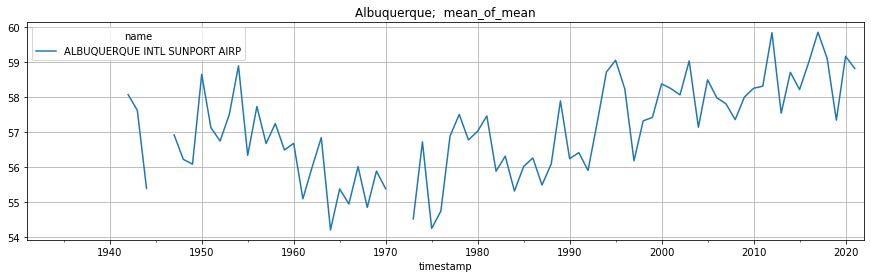

In [29]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Billings;  mean_of_mean'}, xlabel='timestamp'>

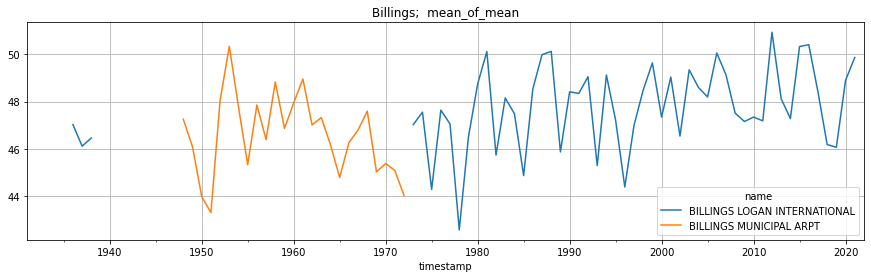

In [30]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Boise;  mean_of_mean'}, xlabel='timestamp'>

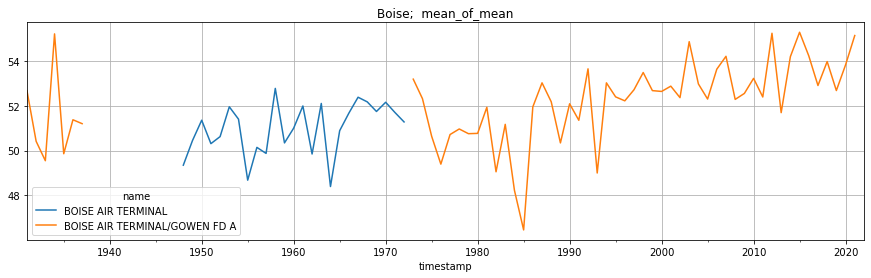

In [31]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Calgary;  mean_of_mean'}, xlabel='timestamp'>

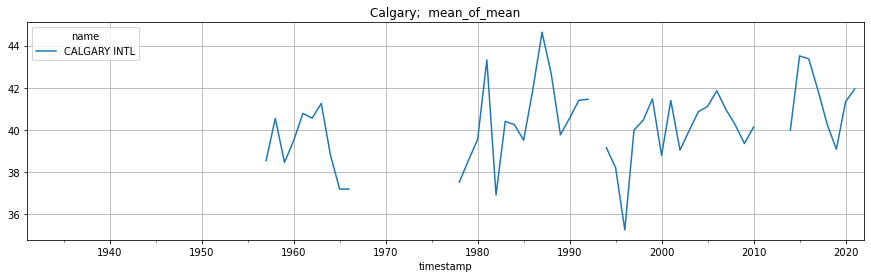

In [32]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Cheyenne;  mean_of_mean'}, xlabel='timestamp'>

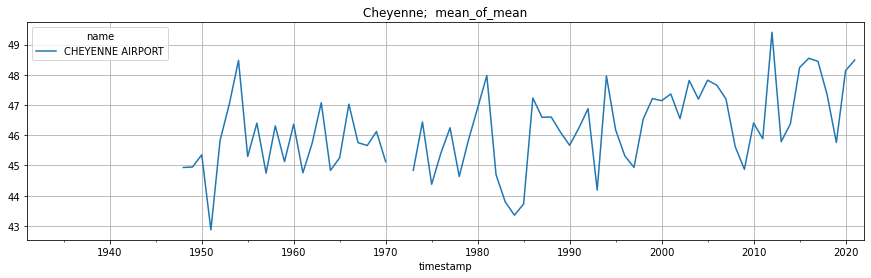

In [33]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Denver;  mean_of_mean'}, xlabel='timestamp'>

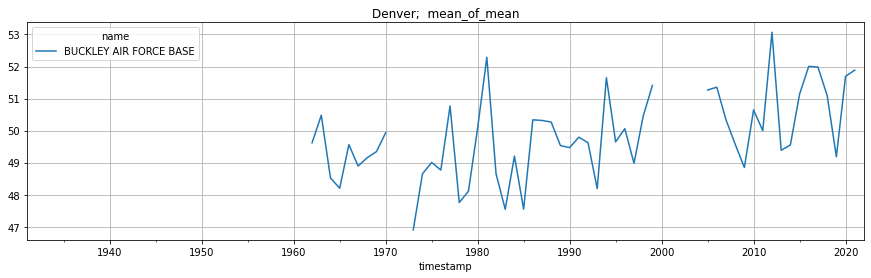

In [34]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Edmonton;  mean_of_mean'}, xlabel='timestamp'>

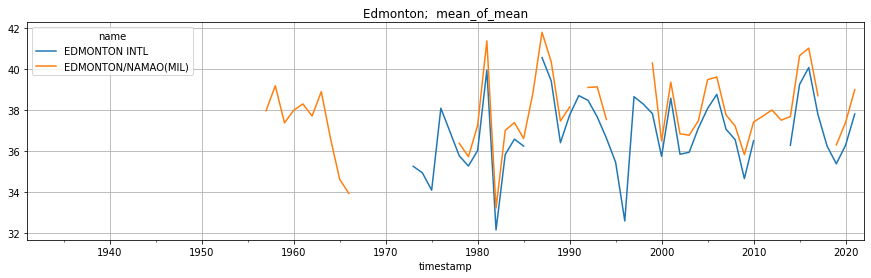

In [35]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Eugene;  mean_of_mean'}, xlabel='timestamp'>

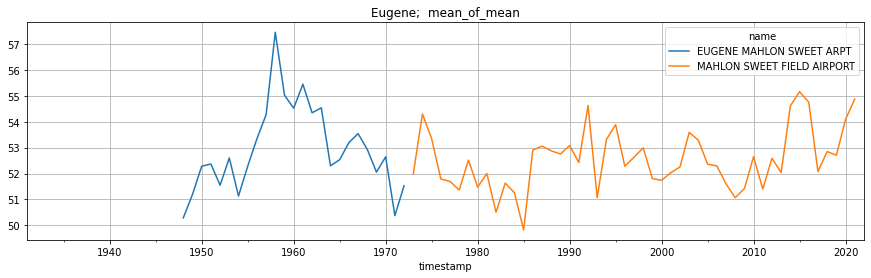

In [36]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Las Vegas;  mean_of_mean'}, xlabel='timestamp'>

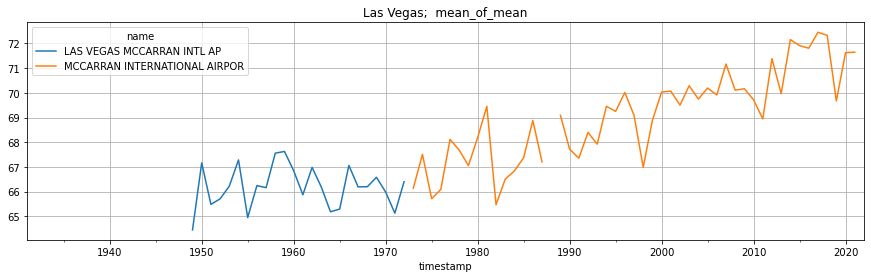

In [37]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Los Angeles;  mean_of_mean'}, xlabel='timestamp'>

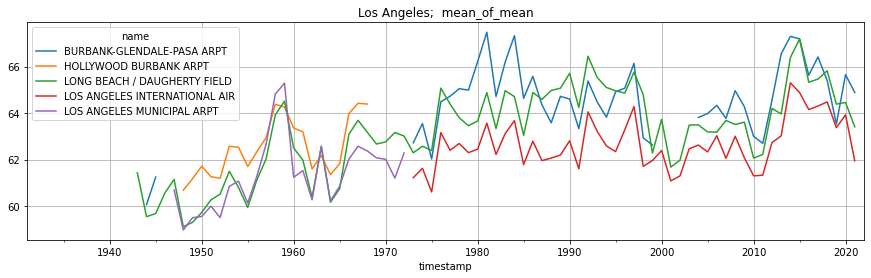

In [38]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Phoenix;  mean_of_mean'}, xlabel='timestamp'>

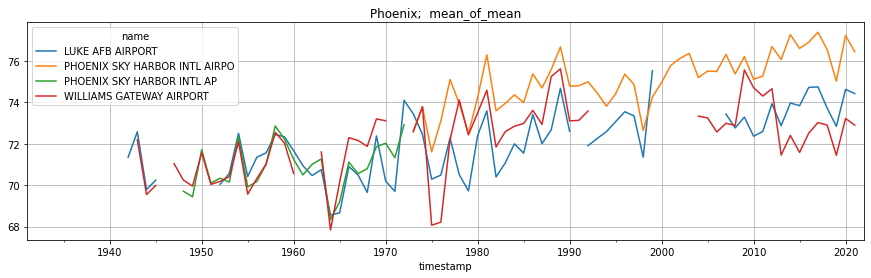

In [39]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Portland;  mean_of_mean'}, xlabel='timestamp'>

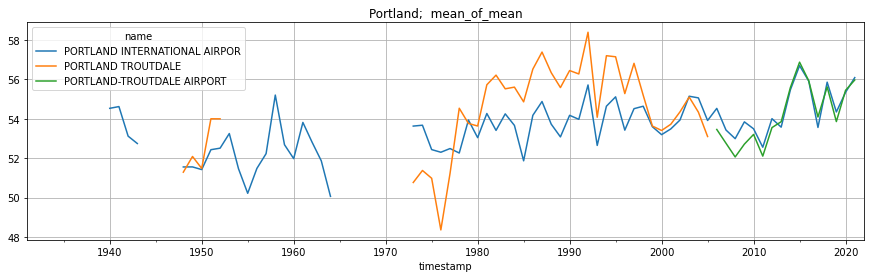

In [40]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Reno;  mean_of_mean'}, xlabel='timestamp'>

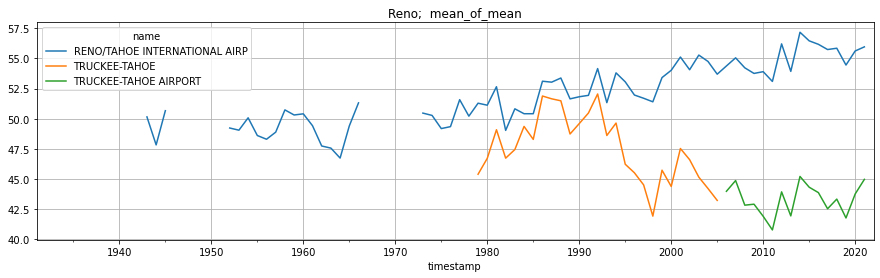

In [41]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Salt Lake City;  mean_of_mean'}, xlabel='timestamp'>

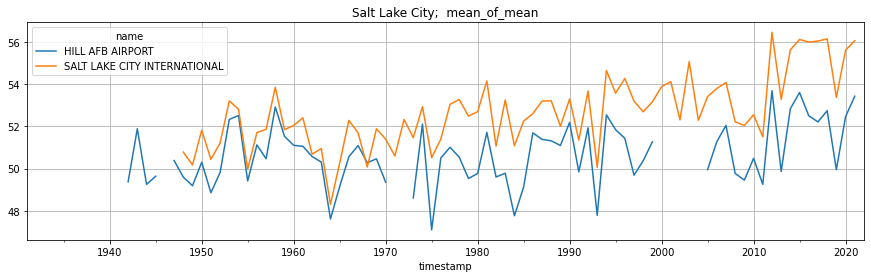

In [42]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'San Diego;  mean_of_mean'}, xlabel='timestamp'>

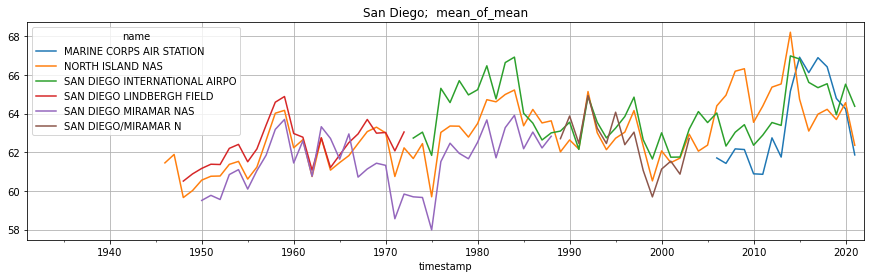

In [43]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'San Francisco;  mean_of_mean'}, xlabel='timestamp'>

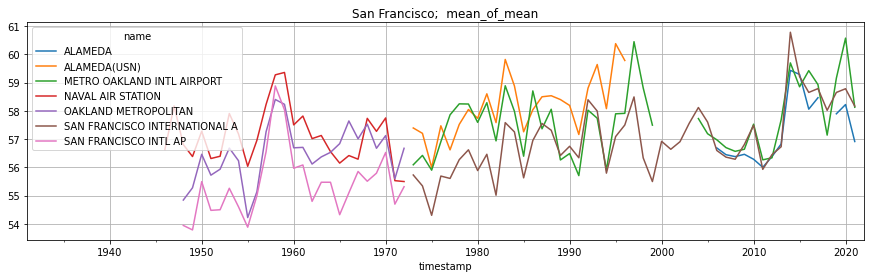

In [44]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Seattle;  mean_of_mean'}, xlabel='timestamp'>

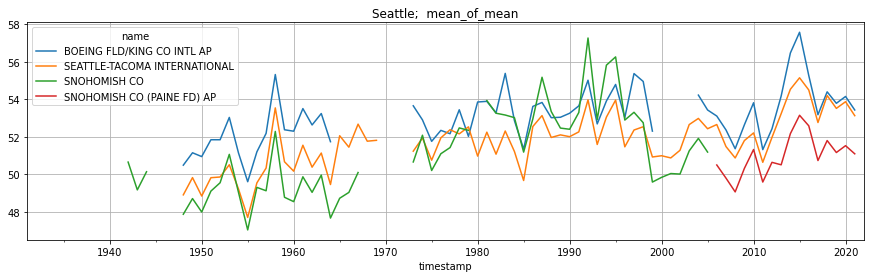

In [45]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Spokane;  mean_of_mean'}, xlabel='timestamp'>

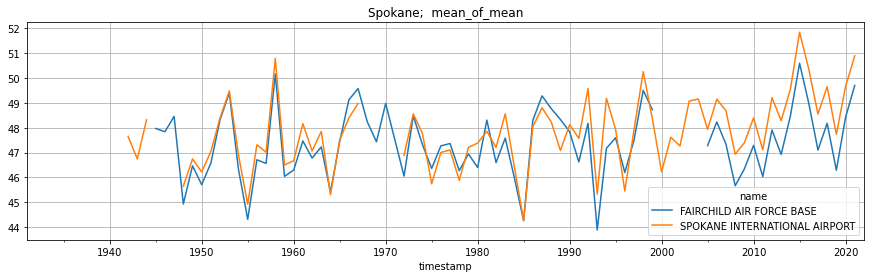

In [46]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Tucson;  mean_of_mean'}, xlabel='timestamp'>

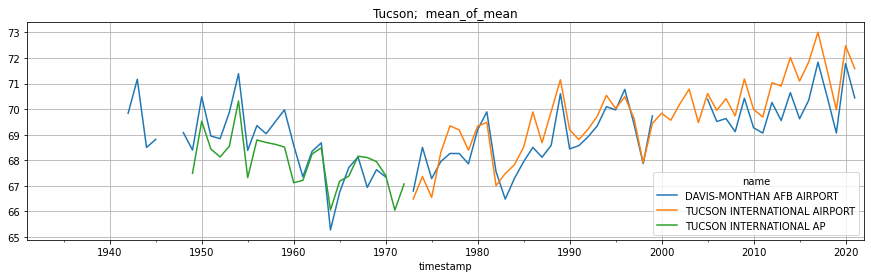

In [47]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Vancouver;  mean_of_mean'}, xlabel='timestamp'>

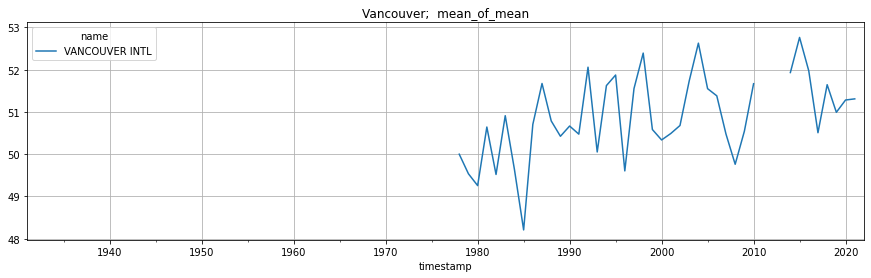

In [48]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

In [49]:
city, df = next(city_iter)
df = df.set_index(['name', 'timestamp'])
if drop_qc_fails:
    qc_col = 'good_temp_coverage' if 'precip' not in col_to_viz else 'good_precip_coverage'
    viz = df[col_to_viz].where(df[qc_col]) # else set nan
else:
    viz = df[col_to_viz]
viz.unstack(level='name').plot(title=f"{city};  {col_to_viz}", grid=True, figsize=(15,4), xlim=('1931-01-01', '2022-01-01'))

StopIteration: 

## Crude Trend Analysis
I'll average together the stations in each city (at annual resolution). This can have big selection bias depending on which stations are available at which time. But for a first look it is good enough.

In [50]:
annual['qc_temp'] = annual['mean_of_mean'].where(annual['good_temp_coverage']) # else nan
city_temps = annual.groupby(['nearest_city', 'timestamp'], as_index=False)['qc_temp'].mean()

In [51]:
city_temps['year'] = city_temps['timestamp'].dt.year

<AxesSubplot:title={'center':'Annual Average Temperatures for Each City, referenced to 1980 (set to 0).'}, xlabel='timestamp'>

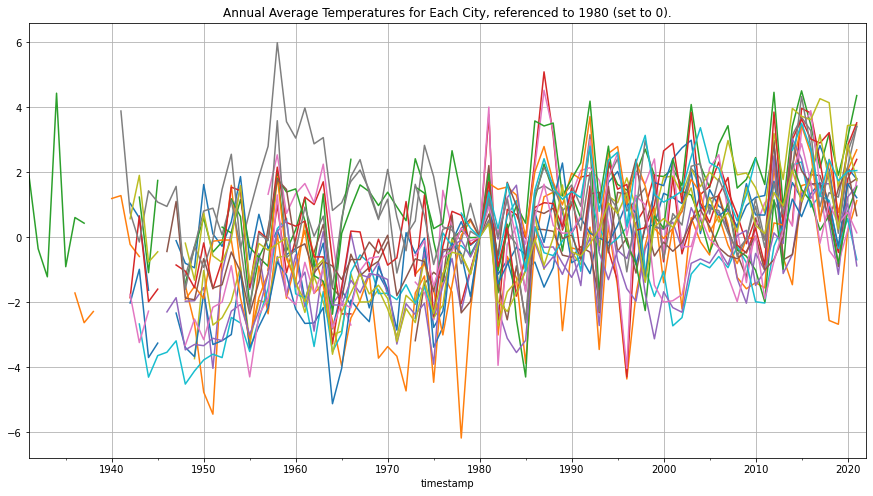

In [52]:
# set 1980 = 0 and plot
centered_city_temps = city_temps.set_index(['nearest_city', 'timestamp'])['qc_temp'].unstack('nearest_city')
centered_city_temps -= centered_city_temps.loc['1980-01-01']
centered_city_temps.plot(figsize=(15,8), grid=True, legend=False, title="Annual Average Temperatures for Each City, referenced to 1980 (set to 0).")

<AxesSubplot:xlabel='nearest_city', ylabel='nearest_city'>

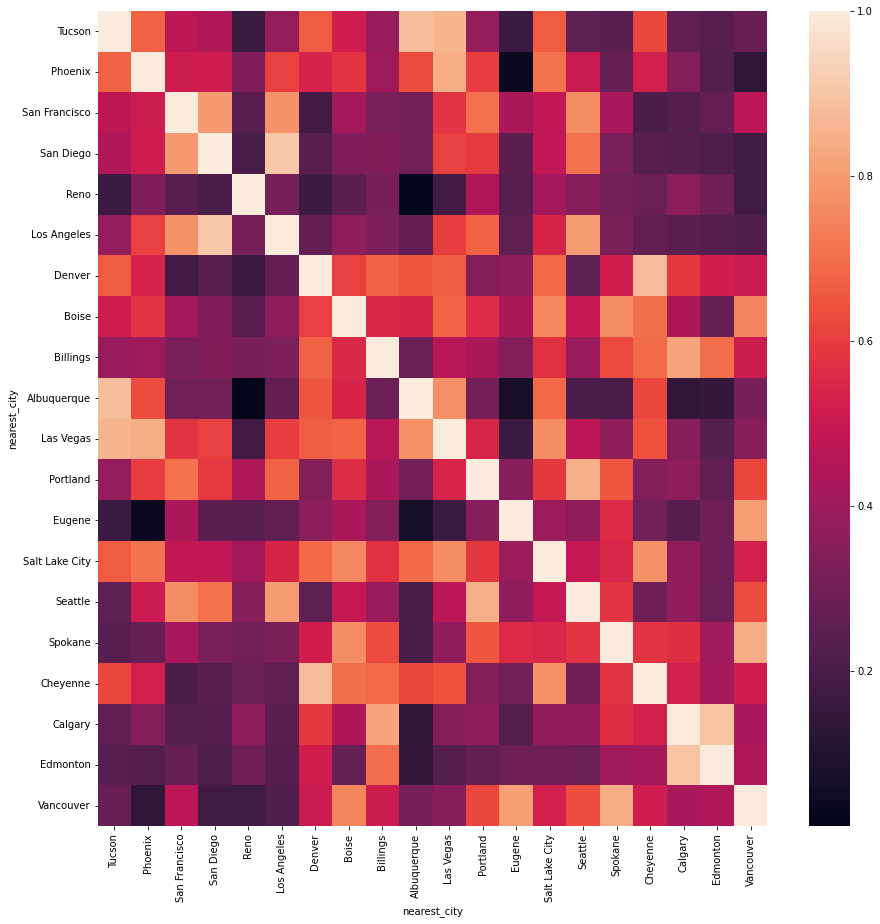

In [53]:
plt.figure(figsize = (15,15))
city_order = best_station_meta.sort_values('state')['nearest_city'].drop_duplicates().to_list()
sns.heatmap(city_temps.set_index(['nearest_city', 'timestamp'])['qc_temp'].unstack('nearest_city')[city_order].corr())

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
reg = LinearRegression(fit_intercept=True)
example_city = city_temps.query('nearest_city == "Billings"').dropna()
reg.fit(X=example_city['year'].to_numpy().reshape(-1,1), y=example_city['qc_temp'].to_numpy().reshape(-1,1))

LinearRegression()

In [56]:
reg.coef_[0][0], reg.intercept_[0]

(0.026602890809666338, -5.339763454187434)

In [57]:
def linear_coefficients(df) -> pd.DataFrame:
    reg = LinearRegression(fit_intercept=True)
    input_ = df.loc[:, ['year', 'qc_temp']].dropna()
    reg.fit(X=input_['year'].to_numpy().reshape(-1,1), y=input_['qc_temp'].to_numpy().reshape(-1,1))
    return pd.DataFrame({'coeff': [reg.coef_[0][0]], 'intercept': [reg.intercept_[0]]})

In [58]:
linear_coefficients(example_city)

,coeff,intercept
0,0.026603,-5.339763


In [59]:
lin_reg = city_temps.groupby('nearest_city').apply(linear_coefficients).droplevel(level=1)

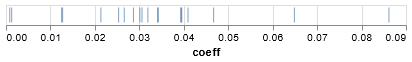

In [60]:
# all positive
alt.Chart(lin_reg.reset_index()).mark_tick().encode(
    x='coeff:Q',
    
)

In [61]:
lin_reg

,coeff,intercept
nearest_city,,
Albuquerque,0.030119,-2.644075
Billings,0.026603,-5.339763
Boise,0.034265,-16.032321
Calgary,0.030589,-20.698152
Cheyenne,0.028675,-10.736631
Denver,0.039541,-28.892451
Edmonton,0.012740,11.938521
Eugene,0.001277,50.149193
Las Vegas,0.086150,-102.866915


<AxesSubplot:xlabel='name', ylabel='name'>

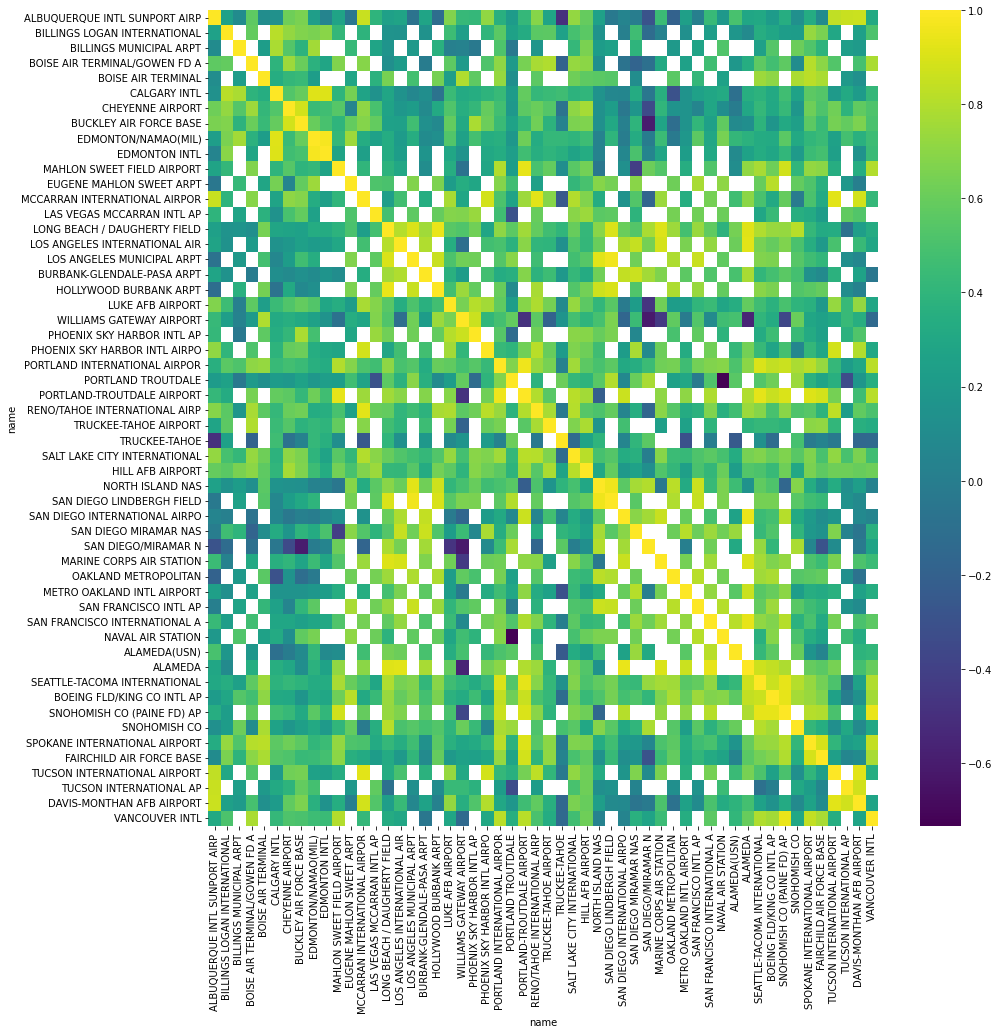

In [62]:
city_order = best_station_meta['name'].to_list()
plt.figure(figsize = (15,15))
sns.heatmap(annual.pivot_table(values='qc_temp', index='timestamp', columns='name')[city_order].corr(), cmap='viridis')